In [1]:
%matplotlib inline

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import glob


In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import random
import pathlib

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
tf.__version__

'2.0.0'

In [6]:
def get_image_paths_labels(root_path):
    '''Ref: CS230 TA Session 5 : Tesorflow vs Pytorch 
    Link: https://colab.research.google.com/drive/1HzN2f0Mypj0r2rKJdKYCjczM1WzJyoaV#scrollTo=lzBchLwtgHk7
    '''
    all_image_paths = [f for f in root_path.glob("**/*.jpg")]
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths) 

    label_names = sorted(item.name for item in root_path.glob('*/') if item.is_dir())
    
    print("Label names are {}".format(label_names))
    
    label_to_index = dict((name, index) for index,name in enumerate(label_names))
    print("Label to index are {}".format(label_to_index))
    
    all_image_label_text = [pathlib.Path(path).parent.name for path in all_image_paths]
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
    #print("All labels are {} : {}".format(all_image_words, all_image_labels))
    return all_image_paths, all_image_labels, all_image_label_text


data_filepath="/home/hnkulkarni/nn/CS230/Project/trashnet/data/dataset-resized/dataset-resized/"
data_root = pathlib.Path(data_filepath)
image_paths, image_labels, image_label_text = get_image_paths_labels(data_root)

Label names are ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Label to index are {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [7]:
def random_select_images_labels(image_paths, image_labels, k):
    '''Select different images and labels'''
    l1 = len(image_paths)
    l2 = len(image_labels)
    if l1 != l2: # Make sure the lengths are same before going forward 
        print("Number of images not equal to number of labels")
        raise
        
    rdm_idx = np.random.choice(range(len(image_labels)), k)
    
    rdm_image_paths = [image_paths[i] for i in rdm_idx]
    rdm_image_labels = [image_labels[i] for i in rdm_idx] 
    
    return rdm_image_paths, rdm_image_labels

rdm_image_paths, rdm_image_labels_text = random_select_images_labels(image_paths, 
                                                                image_label_text, 
                                                                4)
print("Random files are {}".format(rdm_image_paths))
print("Random labels are {}".format(rdm_image_labels_text))

Random files are ['/home/hnkulkarni/nn/CS230/Project/trashnet/data/dataset-resized/dataset-resized/metal/metal220.jpg', '/home/hnkulkarni/nn/CS230/Project/trashnet/data/dataset-resized/dataset-resized/glass/glass226.jpg', '/home/hnkulkarni/nn/CS230/Project/trashnet/data/dataset-resized/dataset-resized/trash/trash42.jpg', '/home/hnkulkarni/nn/CS230/Project/trashnet/data/dataset-resized/dataset-resized/paper/paper320.jpg']
Random labels are ['metal', 'glass', 'trash', 'paper']


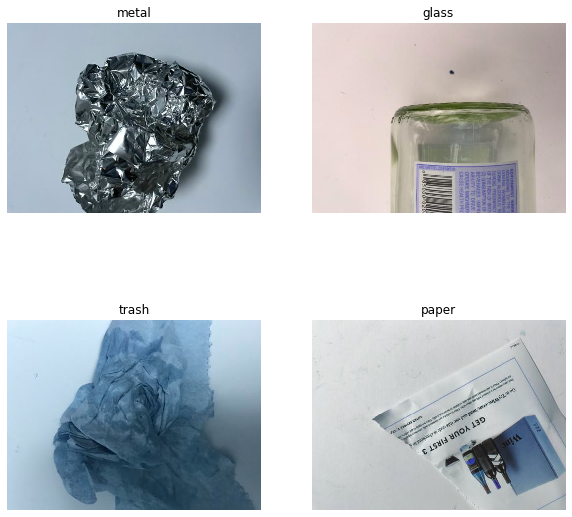

In [8]:
'''
We first verify that the dataset was loaded correctly
by viewing the images using opencv. Takes list of paths as input
Ref: CS230 TA Session 5 : Tesorflow vs Pytorch 
Link: https://colab.research.google.com/drive/1HzN2f0Mypj0r2rKJdKYCjczM1WzJyoaV#scrollTo=lzBchLwtgHk7
'''
def view_dataset_paths(paths, labels, method='cv2'):
    N = len(paths)
    cols = 2
    rows = int(np.ceil(N / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    flatted_axs = [item for one_ax in axs for item in one_ax]
    for ax, path, label in zip(flatted_axs, paths, labels):
        if method == 'cv2':
            try:
                img = cv2.imread(path, 3)
            except:
                print("Error in reading path")
        elif method == 'tf':
            img = try_tf_image(path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show() 

view_dataset_paths(rdm_image_paths, rdm_image_labels_text)

In [9]:
'''
We verify that the dataset was loaded correctly
by viewing the images using opencv.
Takes list of images as input
Ref: CS230 TA Session 5 : Tesorflow vs Pytorch 
Link: https://colab.research.google.com/drive/1HzN2f0Mypj0r2rKJdKYCjczM1WzJyoaV#scrollTo=lzBchLwtgHk7
'''

def view_dataset_images(list_imgs, labels, method='cv2'):
    N = len(list_imgs)
    cols = 2
    rows = int(np.ceil(N / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    flatted_axs = [item for one_ax in axs for item in one_ax]
    
    for ax, img, label in zip(flatted_axs, list_imgs, labels):
        img = np.squeeze(img)
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
        ax.axis('off')
    plt.show() 

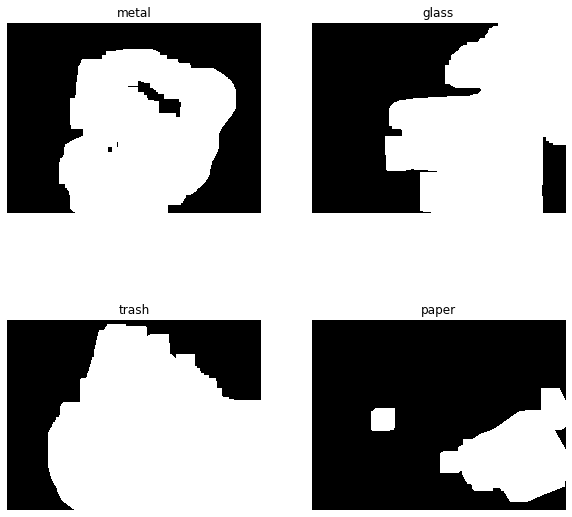

In [10]:
def forground_mask(img):
    '''Ref: Grab-cut using 
        Link: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_grabcut/py_grabcut.html
        
    '''
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # noise removal
    kernel = np.ones((10, 10),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

#     # Finding sure foreground area
#     dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
#     ret, sure_fg = cv2.threshold(dist_transform,0.001*dist_transform.max(),255,0)

    cv2.normalize(sure_bg, sure_bg, 0, 1, cv2.NORM_MINMAX)
    
    return sure_bg

rdm_cv_imgs = [cv2.imread(path, 3) for path in rdm_image_paths] 
fgms = [forground_mask(img) for img in rdm_cv_imgs ] 
view_dataset_images(fgms, labels=rdm_image_labels_text, method='cv2')

In [11]:
np.max(fgms[0])

1

In [12]:
x_train = np.array([f for f in fgms])

In [13]:
x_train.shape

(4, 384, 512)

In [14]:
x_train = np.reshape(x_train, (x_train.shape[0], 
                               x_train.shape[1],
                               x_train.shape[2],
                              1))

In [15]:
x_train.shape

(4, 384, 512, 1)

In [16]:
num_training, train_rows, train_cols, channels = x_train.shape

In [17]:
x_train[0].shape

(384, 512, 1)

In [18]:
len(x_train[0].shape)

3

In [54]:
def transform(mask, hm, verbose=False):
    '''Given a mask, it transforms using the homogeneous matrix given'''
    '''hm = [tx, ty, s, theta]'''
    tx, ty, theta, s = hm
    
    if len(mask.shape) != 3:
        print("Image of rows * col * ch is needed. Dimension {} given".
             format(len(mask.shape)))
        
    rows,cols, ch = mask.shape
    ## Translate
    M_translate = np.float32([[1, 0, tx], [0, 1, ty]])
    
    # Setting the border to reflect so that we do not waste data - borderMode=cv2.BORDER_WRAP
    dst_translate = cv2.warpAffine(mask, M_translate, (cols,rows))
    
    if verbose == True:
        print("Translating by \n{}".format(M_translate))
    
    #Rotate and Scale
    M_rotate = cv2.getRotationMatrix2D((cols/2,rows/2),theta,s)
    
    # Setting the border to reflect so that we do not waste data - borderMode=cv2.BORDER_WRAP
    dst_rotate = cv2.warpAffine(dst_translate, M_rotate, (cols,rows) )
    if verbose == True:
        print("Rotating by \n{}".format(M_rotate))
    
    if ch == 1: # Normalize only if color image
        cv2.normalize(dst_rotate, dst_rotate, 0, 1, cv2.NORM_MINMAX)
        
    if verbose == True:
        print("Max: {}".format(np.max(dst_rotate)))
        
    dst_rotate = np.reshape(dst_rotate, mask.shape)
    return dst_rotate

Tiled transformations: 
[[-90  90  45   1]
 [-90  90  45   1]
 [-90  90  45   1]
 [-90  90  45   1]]


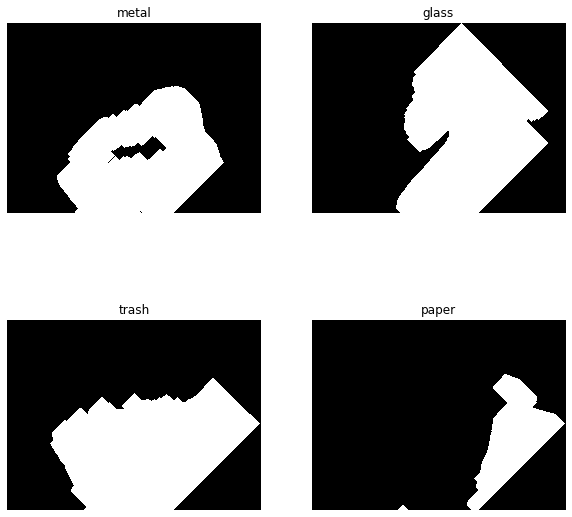

In [58]:
default_transformation = np.array([-90, 90, 45, 1])
#print("Default Transformation {}".format(default_transformation))

list_hm = np.tile(default_transformation, (num_training, 1))
print("Tiled transformations: \n{}".format(list_hm))

#rdm_cv_imgs
list_masks = [transform(mask=msk, hm=hm)  for msk, hm in zip(x_train, list_hm)]

view_dataset_images(list_imgs = list_masks, 
                   labels = rdm_image_labels_text,
                   method='cv2')


In [21]:
list_masks = np.asarray(list_masks, dtype='float32')
list_masks /= 255.0

In [22]:
def mask_union(masks_to_merge):
    print(masks_to_merge.shape)
    num_training, train_rows, train_cols, channels = masks_to_merge.shape
    
    merge_resulting = np.zeros((train_rows, train_cols, channels), dtype='float32')
    print(merge_resulting.shape)
    for i in range(num_training):
        #print(masks_to_merge[i].shape)
        merge_resulting = cv2.bitwise_or(merge_resulting, masks_to_merge[i])
        
    return merge_resulting

In [23]:
def mask_intersection(masks_to_merge):
    print(masks_to_merge.shape)
    num_training, train_rows, train_cols, channels = masks_to_merge.shape
    
    merge_resulting = np.ones((train_rows, train_cols, channels), dtype='float32')
    print(merge_resulting.shape)
    for i in range(num_training):
        #print(masks_to_merge[i].shape)
        merge_resulting = cv2.bitwise_and(merge_resulting, masks_to_merge[i])
        
    return merge_resulting

(4, 384, 512, 1)
(384, 512, 1)


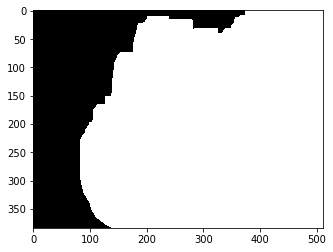

In [24]:
def merge_masks(masks_to_merge):
    '''Merge list of masks into one mask'''
    merge_resulting = mask_union(masks_to_merge=masks_to_merge)
    return merge_resulting
    
    
merged_masks = merge_masks(masks_to_merge=list_masks)
plt.imshow(merged_masks, cmap='gray')

(4, 384, 512, 1)
(384, 512, 1)


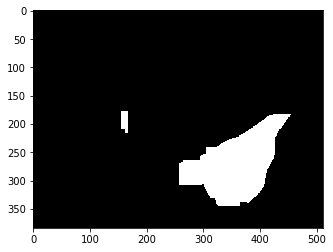

In [25]:
merge_intersection = mask_intersection(masks_to_merge=list_masks)
plt.imshow(merge_intersection, cmap='gray')

In [26]:
def collage_loss(list_masks):
    merge_union = mask_union(masks_to_merge=list_masks)
    merge_intersection = mask_intersection(masks_to_merge=list_masks)
    
    intersection_scr = np.sum(merge_intersection)
    print("Intersection Score {}".format(intersection_scr))
    
    union_scr = np.sum(merge_union)
    print("Union score {}".format(union_scr))
    
    individual_sums = [np.sum(lm) for lm in list_masks]
    print("individual_sums {}".format(individual_sums))
    
    individual_sum_of_sums = np.sum(individual_sums)
    print("individual_sum_of_sums {}".format(individual_sum_of_sums))
    
    combined_loss = (individual_sum_of_sums - union_scr) - intersection_scr
    print("combined_loss {}".format(combined_loss))
    
    return combined_loss

collage_loss(list_masks)

(4, 384, 512, 1)
(384, 512, 1)
(4, 384, 512, 1)
(384, 512, 1)
Intersection Score 64.8125
Union score 571.3882446289062
individual_sums [349.1059, 399.04706, 480.92166, 142.45883]
individual_sum_of_sums 1371.533447265625
combined_loss 735.3327026367188


735.3327